## eco-velo on pancreas

In this notebook we will apply our eco-velo method to the pancreas endocrinogenesis dataset. This dataset was originally published by Bastidas-Ponce and colleagues (https://doi.org/10.1242/dev.173849). 


In [3]:
### load libraries

# general libraries
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree

# other
import sklearn as sk #used for L2 normalization
import time #to measure time of script running

%load_ext autoreload
%autoreload 2
# import our own functions
import velocity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
### current timestamp
begin_time = time.time()

### Load original dataset

First, load the pancreas endocrinogenesis dataset. The dataset is made accesible in the scVelo package (version 0.2.4) and can be downloaded using the function `scvelo.datasets.pancreas()`. 

In [5]:
### load pancreas dataset
pancreas_path = "../datasets/pancreas/pancreas.h5ad"
import anndata as ad
adata = ad.read_h5ad(pancreas_path) 

### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

## Prepare the data

Process the dataset for eco-velo analysis. Please refer to https://doi.org/10.1101/2022.03.17.484754If to know more about processing. 


- (1) select HVGs, using analytic Pearson residuals (Lause et al., 2021 https://doi.org/10.1186/s13059-021-02451-7).
- (2) filter cell cycle genes, and genes with too low unspliced / spliced counts
- (3) normalise, and log-transform data

#### (1) HVGs

In [6]:
### select HVGs
hvgs = velocity.pp.filtering.get_hvgs(adata, no_of_hvgs=5000, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

/Users/vmarotl/Documents/rna_velocity/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


Subsetting to top 5000 highly-variable genes.


#### (2) filtering

In [7]:
# remove cycling genes
cc_path = "../datasets/pancreas/cell_cycle_markers_all.csv"
cc_markers = pd.read_csv(cc_path, sep=";")
cc_markers = cc_markers["gene"].values
cc_markers = np.unique(cc_markers)
adata = adata[:, [i not in cc_markers for i in adata.var_names]]

In [8]:
### subset for genes that have high enough U and S counts
minlim = 3
us_genes = velocity.pp.filtering.get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 664 genes with sufficient S and U counts.


#### (3) normalise

Log-transform and L2 normalise the dataset. Normalisation is applied to spliced and unspliced counts seperately.

In [9]:
### log transformation of the dataset
adata.X = np.array(np.where(adata.X != 0, np.log(adata.X), 0))
adata.layers['spliced'] = np.array(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
adata.layers['unspliced'] = np.array(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))

<ipython-input-9-4580f657b642>:2: RuntimeWarning: divide by zero encountered in log
  adata.X = np.array(np.where(adata.X != 0, np.log(adata.X), 0))
<ipython-input-9-4580f657b642>:3: RuntimeWarning: divide by zero encountered in log
  adata.layers['spliced'] = np.array(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
<ipython-input-9-4580f657b642>:4: RuntimeWarning: divide by zero encountered in log
  adata.layers['unspliced'] = np.array(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))


In [10]:
### L2 normalise spliced and unspliced separately
adata.layers['spliced'] = sk.preprocessing.normalize(adata.layers['spliced'], norm='l2')
adata.layers['unspliced'] = sk.preprocessing.normalize(adata.layers['unspliced'], norm='l2')

## Calculate new UMAP embedding

Since we removed many of the original genes from the dataset, we will recalculate the UMAP embedding. 

First, we run a PCA on scaled spliced data.

In [11]:
### scale data (spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

In [12]:
### run PCA
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

In [13]:
### calculate UMAP
reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=1, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

In [14]:
# flip s.t. it is in the same orientation as the other figure
UMAP_data[:,1]=-UMAP_data[:,1]

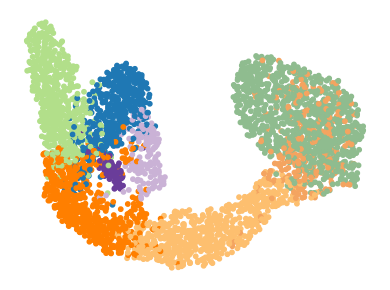

In [15]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
c=adata.obs["clusters"].map(color_dict)

### plot UMAP (just spliced counts)
fig, ax = plt.subplots(1, 1, figsize=(4, 3), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], s=10, c=c)
ax.axis("off")
fig.tight_layout()
plt.show()

## MNN on original gene space

Last in the eco-velo workflow for each cell we will use its unspliced counts to find the mutual nearest neighbour (MNN) between all cells, defined by their spliced counts. 

Note: since we try to find an MNN in the first 50 neighbours, it might be that some cells are not assigned to any MNN.

In [16]:
### identify MNNs
k = 50
mnn = velocity.tl.eco_velo.find_mutual_nn(adata.layers['unspliced'], adata.layers['spliced'], top_n=5, k = k)
print(np.sum(np.all(mnn==-1, axis=1))) # have no neighbors within top top_n

1848


In [17]:
### select MNNs
pos = UMAP_data[mnn]
pos[np.array(mnn)==-1]=np.nan
pos = np.nanmean(pos, axis=1)

<ipython-input-17-c1b3a932b3b1>:4: RuntimeWarning: Mean of empty slice
  pos = np.nanmean(pos, axis=1)


In [18]:
### smoothing; averaging position over nearest neighbours
NN = cKDTree(adata.layers['spliced']).query(x=adata.layers['spliced'], k=30)[1]
pos_mean = np.nanmean(np.array(pos)[NN], axis=1)


To calculate the running time of the complete time of the $\kappa$-velo approach on the pancreas endocrinogenesis dataset, we started a timer all the way at the beginning. Here we stop the time and calculate how much time has passed.

In [19]:
### aaaand cut!
end_time = time.time()

def format_time(t):
  return f"{int(t/3600)}H {int((t/60)%60) if t/3600>0 else int(t/60)}M {int(t%60)}S"

print(format_time(end_time-begin_time))

0H 1M 14S


In [20]:
### get points for UMAP
v = np.array(pos) - UMAP_data
v_mean = pos_mean - UMAP_data

In [21]:
### set arguments for visualisation
light_color = np.array([velocity.pl.utils.lighten_color(i, .3) for i in c])
umap_pltkwargs={"figsize":(10, 8), "frameon":False}
umap_quiver_kwargs = {"scale": 3, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                      "linewidth": 0.5, "headlength": 7, "headwidth": 5, "headaxislength": 6}
sub = np.any(mnn>=0, axis=1)
sub[np.arange(0, len(sub), 5)]=False

In [ ]:
### create UMAP plot (eco-velo visualisation)
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)

ax.scatter(UMAP_data[:,0], UMAP_data[:,1], s=100, c=light_color)
ax.axis("off")
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], v[sub,0], v[sub,1], color=c[sub], **umap_quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/Fig5C_UMAP_pancreas_eco-velo.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

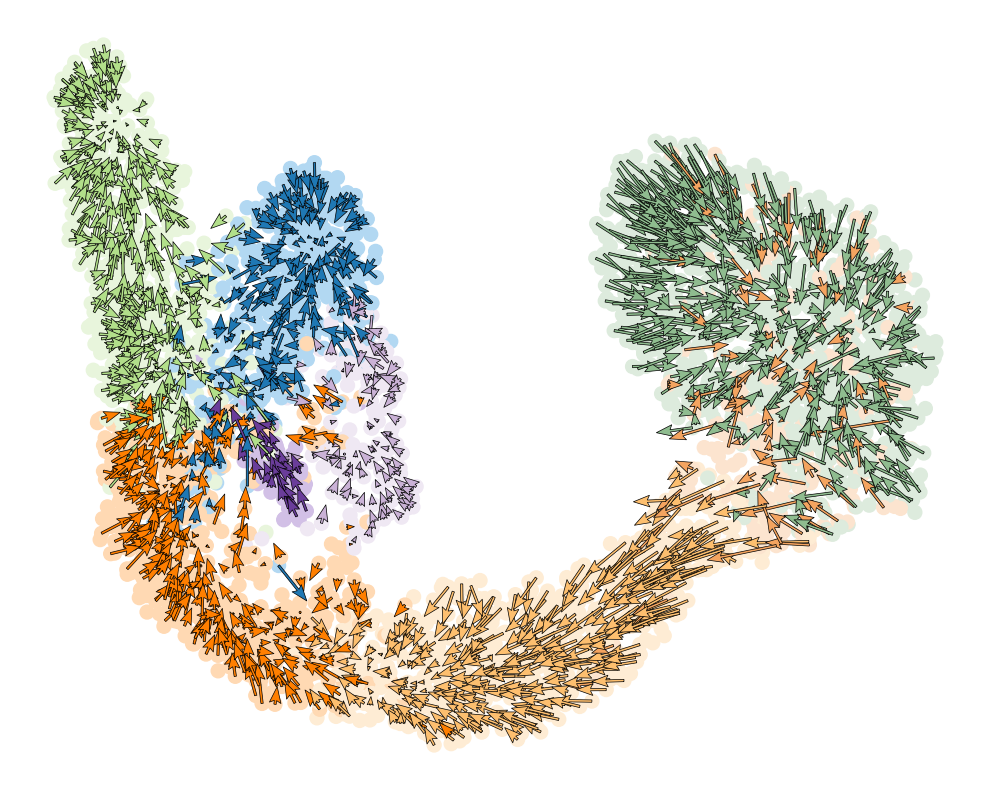

In [22]:
### make smoothed UMAP plot 
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)

ax.scatter(UMAP_data[:,0], UMAP_data[:,1], s=100, c=light_color)
ax.axis("off")
sub = np.any(mnn>=0, axis=1)
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], v_mean[sub,0], v_mean[sub,1], color=c[sub], **umap_quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/pancreas/FigS8_UMAP_pancreas_eco-velo_smoothed.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

## Supplementary figures

#### Comparison to $\kappa$-velo

In [23]:
# import UMAP coordinates and kappa-velo velocities
UMAP_kappa_velo = np.array(pd.read_csv("../datasets/pancreas/umap_coor.csv", index_col=0))
kappa_velo_v = np.array(pd.read_csv("../datasets/pancreas/umap_kappa-velo_velocities.csv", index_col=0))

kappa_velo_v/=np.std(kappa_velo_v)

In [24]:
# project eco-velo on same UMAP
eco_velo_v = UMAP_kappa_velo[mnn]
eco_velo_v[np.array(mnn)==-1]=np.nan
eco_velo_v = np.nanmean(eco_velo_v, axis=1)

v = eco_velo_v - UMAP_kappa_velo
v/=np.nanstd(v)*1

#pos_mean = np.nanmean(np.array(eco_velo_v)[NN], axis=1)
#v = pos_mean - UMAP_kappa_velo
#v/=np.nanstd(v)

<ipython-input-24-cf1ba8ad0024>:4: RuntimeWarning: Mean of empty slice
  eco_velo_v = np.nanmean(eco_velo_v, axis=1)


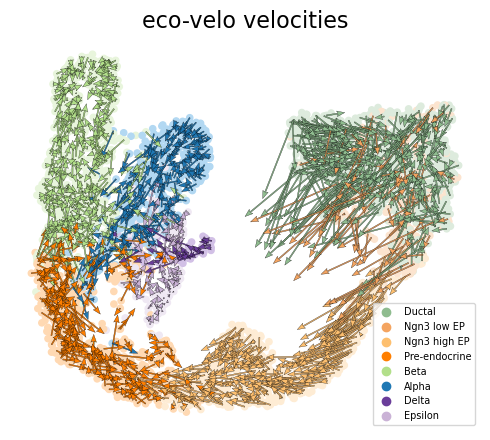

In [25]:
umap_quiver_kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                      "linewidth": 0.2, "headlength": 7, "headwidth": 5, "headaxislength": 6}

### create UMAP plot (eco-velo visualisation)
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))

ax.scatter(UMAP_kappa_velo[:,0], UMAP_kappa_velo[:,1], s=20, c=light_color)
ax.axis("off")
ax.quiver(UMAP_kappa_velo[sub,0], UMAP_kappa_velo[sub,1], v[sub,0], v[sub,1], color=c[sub], **umap_quiver_kwargs)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1, loc="lower right", fontsize=7)
plt.title("eco-velo velocities", fontsize = 16)
fig.tight_layout()

# save figure
save_path = "../figures/pancreas/FigXX_UMAP_pancreas_eco-velo_kappa_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [26]:
from velocity.project.nystroem_utils import vector_distance
### calculate change in direction
a0= vector_distance(v[sub], kappa_velo_v[sub], metric="cosine")
### calculate change in angle
d0 = vector_distance(v[sub], kappa_velo_v[sub], metric="norm_diff")
n0 = vector_distance(v[sub], kappa_velo_v[sub], metric="diff_norm")

/Users/vmarotl/Documents/rna_velocity/velocity_package/velocity/project/nystroem_utils.py:26: RuntimeWarning: invalid value encountered in double_scalars
  [np.dot(v_0[i], v_t[i].T) / (np.linalg.norm(v_0[i]) * np.linalg.norm(v_t[i])) for i in range(v_t.shape[0])])


<ipython-input-27-8d5b24689118>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


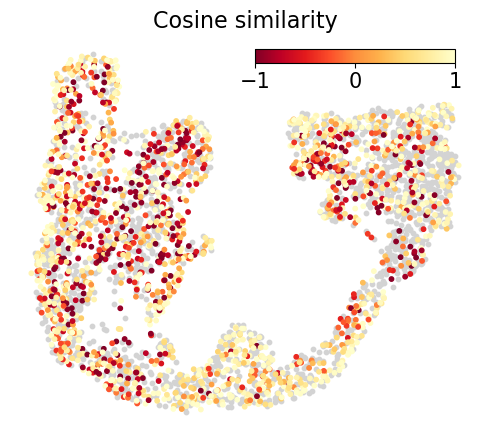

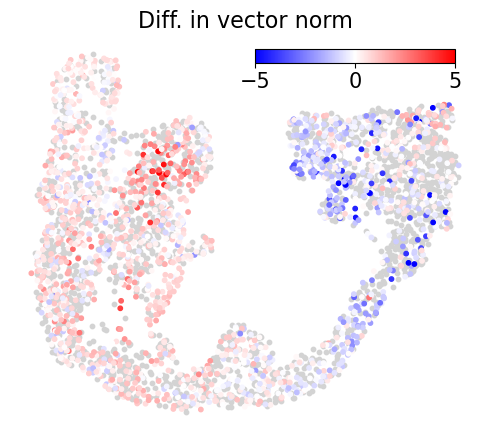

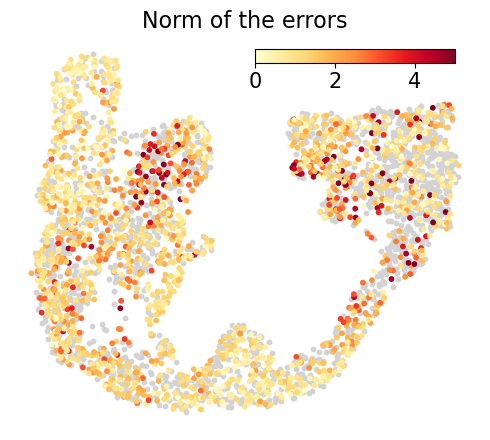

In [27]:
from matplotlib import rcParams # for changing the parameters of the scVelo figures

rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False

titles = ["Cosine similarity", 
         "Diff. in vector norm", 
         "Norm of the errors"]
color = [a0, d0, n0]
cmaps = ["YlOrRd_r", 
         "bwr",
        "YlOrRd"]
vmin_vmax = [(-1, 1),  
             (-5, 5),
             (0, 5)]
save_name = ["fig_cosine_pancreas_eco_velo", 
             "fig_norm_pancreas_eco_velo",
             "fig_errors_pancreas_eco_velo"]
for i in range(3):
    fig, axs = plt.subplots(1,1, figsize=(5, 4.5), frameon=False)
    vmin, vmax=vmin_vmax[i]
    axs.scatter(UMAP_kappa_velo[~sub,0], UMAP_kappa_velo[~sub,1], s=10, color="lightgrey",alpha=1)
    im = axs.scatter(UMAP_kappa_velo[sub,0], UMAP_kappa_velo[sub,1], s=10, c=color[i], alpha=1, 
                     vmin=vmin, vmax=vmax, cmap=cmaps[i])
    cax = fig.add_axes([0.52, 0.85, 0.4, 0.03])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=15)
    #cbar.ax.set_yticklabels(["0", "1", "3", "4"], fontsize=10)
    axs.set_title(titles[i], fontsize=16)
    axs.set_yticks([])
    axs.set_xticks([])
    plt.tight_layout()
    plt.savefig("../figures/pancreas/"+save_name[i], dpi=300, transparent=True)

plt.show()